# Adversarial Robust Deep Hedging
#### Exploring the Black-Scholes Model
(Example 7.3)

In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.BlackScholesCoefficient import BlackScholesCoefficientConfig, BlackScholesDriftCoefficient, BlackScholesDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.penalty.CompareVolatility import CompareVolatility, VolatilityComparisonConfig
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesParameterSet, BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger

## Initialize

### Reference model and generator 

We begin by initializing the true market model. We choose the following paramters for demonstration. 

In [2]:
bs_parameters = BlackScholesParameterSet(drift=0.0, sigma=0.2)
initial_asset_price = 1.0

Moreover, we need the following market parameters:

In [3]:
trading_freq: int = 5
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

This allows us to define a generator for the true underlying model: 

In [4]:
reference_generator = BlackScholesGenerator(
    drift=np.array([bs_parameters.drift]),
    sigma=np.array([bs_parameters.sigma]),
).provide_generator(
    initial_value=np.array([initial_asset_price]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)

### Generate small data environments

We now generate `number_of_scenarios` scenarios, where we only few paths from the reference model given.

In [5]:
number_of_scenarios = 1000

In [6]:
scenarios = [reference_generator(30) for _ in range(number_of_scenarios)] 

### Define corresponding penalties

We can now initialize penalties that determine the distance to the generated paths in each scenario. 

In [7]:
pen_config = VolatilityComparisonConfig(td)
penalizers = [
    CompareVolatility(scenario, pen_config, transform=lambda x: 0.8 * x) for scenario in scenarios
]

They measure the distance of generated paths by considering the distance to the heuristic volatility. 

In [8]:
volatilities_for_scenarios = [torch.mean(pen.original_volatility).item() for pen in penalizers]

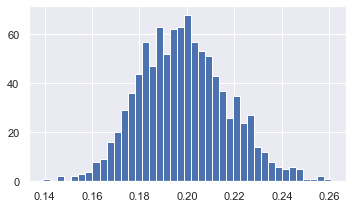

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(5,3))
axs.hist(volatilities_for_scenarios, bins=41)
plt.tight_layout()
plt.show()

### Initialize generators

With this, we can now initialize an `SdeGenerator` that has `BlackScholesCoefficient` corresponding to the above estimates. 

Note that formally these would be calibrated to the data in this step, but we omit this, since the result is obviously equivalent. 

In [10]:
generators = []
for vol in volatilities_for_scenarios:
    coef_config = BlackScholesCoefficientConfig(
        BlackScholesParameterSet(drift=bs_parameters.drift, sigma=vol),
        initial_asset_price=1.0,
    )
    drift_coef, diffusion_coef = BlackScholesDriftCoefficient(coef_config), BlackScholesDiffusionCoefficient(coef_config)
    gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
    generators.append(SdeGenerator(generator_config=gen_config))

We disable the training for all drift parameters:

In [11]:
for g in generators:
    g.drift.drift.requires_grad = False

### Noise Generator
In order to utilize the generator, we require a noise generator. In this case, this is a simple Brownian motion generator:

In [12]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(1),
    times=td.times,
    random_number_generator=np.random.default_rng(4444),
)

We can now verify that the generators are initialized accordingly.

In [13]:
# initialization_errors = [p(g(noise_generator(1000))).item() for g, p in tqdm(zip(generators, penalizers), total=1000)]

In [14]:
# fig, axs = plt.subplots(1, 1, figsize=(5,3))
# axs.hist(initialization_errors, bins=41)
# plt.tight_layout()
# plt.show()

## Deep Hedging

We will now train a deep hedge on each of the individual models. This has tow purposes

1. we use these deep hedges as pre-trained components for the actual application of the robust hedge GAN, and
2. we will use these hedges to compare the robust hedge GAN on out-of-sample generated data against.

### Initialization 

We begin by setting a hedging objective, since it remains the same over all models. 

In [15]:
hedge_objective = MeanVariance(84)

Next, we define the deep hedges.

In [16]:
deep_hedges = []
for g in generators:
    strategy_config = StrategyNetConfig(dimension_of_asset=1, number_of_layers=3, nodes_in_intermediate_layers=36)
    initial_asset_price_for_deep_hedge = torch.tensor([initial_asset_price], dtype=torch.float32)
    deep_hedges.append(DeepHedge(DeepHedgeConfig(derivative, initial_asset_price_for_deep_hedge, strategy_config)))

### Training

We will now train each individual hedge on the corresponding generator. For this we will use 

In [17]:
sample_size = 50000
batch_sizes_for_epoch = [100]*2 + [1000]*2 + [10000]*1

In [70]:
losses_for_scenarios = []

for i, dh in tqdm(enumerate(deep_hedges), total=number_of_scenarios):
    
    try:
        dh.load_state_dict(torch.load(f'resources/network-states/bs_test/scenario_{i}.pt'))
        
    except FileNotFoundError:
        dh.train()

        generated = ConvertToIncrements()(generators[i](noise_generator(sample_size)).detach())
        opt = torch.optim.Adam(dh.parameters())

        losses = QuantityLogger()
        bbar = tqdm(batch_sizes_for_epoch, leave=False)
        for batch_size in bbar:
            losses.set_mark()
            pbar = tqdm(
                [generated[bno:min(bno + batch_size, sample_size)] for bno in range(0, sample_size, batch_size)],
                leave=False,
            )
            for batch in pbar:
                pnl = dh(batch)
                loss = hedge_objective(pnl)
                dh.zero_grad()
                loss.backward()
                opt.step()

                losses.update(loss.item())
                pbar.set_postfix({'Loss': losses.average_since_mark})

            bbar.set_postfix({'Loss': losses.average_since_mark})

        torch.save(dh.state_dict(), f'resources/network-states/bs_test/scenario_{i}.pt') 
        losses_for_scenarios.append(losses)
    

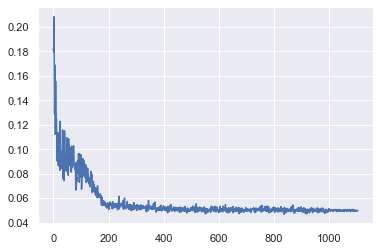

In [19]:
plt.plot(np.load('resources/network-states/bs_test/losses.npz', allow_pickle=True)['scenario_0'])
plt.show()

In [20]:
# Safe loss curves
losses_dict = {f'scenario_{i}': np.array(l.history) for i, l in enumerate(losses_for_scenarios)}
np.savez('resources/network-states/bs_test/losses.npz', **losses_dict)

### Testing 

In [65]:
# (We initialize the reference generator to reset the RNG)
reference_generator = BlackScholesGenerator(
    drift=np.array([bs_parameters.drift]),
    sigma=np.array([bs_parameters.sigma]),
).provide_generator(
    initial_value=np.array([initial_asset_price]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
test_data = torch.diff(reference_generator(10000), 1, 1)

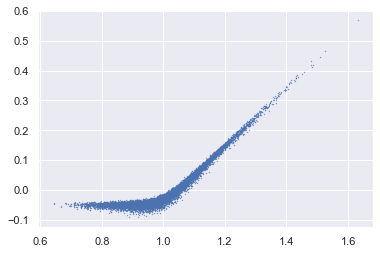

In [66]:
deep_hedges[0].eval()
deep_hedge_results = np.sum(deep_hedges[0](test_data).detach().numpy() * test_data.numpy(), axis=(1, 2))
terminal_values_on_test = np.sum(test_data.numpy(), axis=1)[:, 0] + 1.0
plt.scatter(terminal_values_on_test, deep_hedge_results, s=.1)
deep_hedges[0].train()
plt.show()

In [71]:
oosp = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

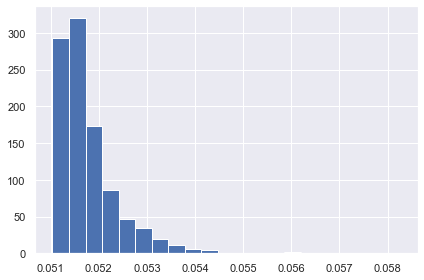

In [26]:
plt.hist(oosp, bins=21)
plt.tight_layout()
plt.show()

### Robust Hedge GAN

In [27]:
robust_dh_gans = []
for dh, p, g in zip(deep_hedges, penalizers, generators):
    g_opt = torch.optim.Adam(g.parameters())
    gen_adapters = AdapterList([])
    gen_train_config = SdeGeneratorTrainerConfig(g, p, g_opt, gen_adapters)
    
    h_opt = torch.optim.Adam(dh.parameters())
    hedge_adapters = AdapterList([ConvertToIncrements()])
    dh_train_config = DeepHedgeTrainerConfig(dh, hedge_objective, h_opt, hedge_adapters)

    robust_dh_gans.append(RobustDhGan(
        hedge_config=dh_train_config,
        gen_config=gen_train_config,
        trainer_config=TrainerConfig(1000, 100000, noise_generator, 1),
    ))

## Training

In [31]:
for i, rh_gan in tqdm(enumerate(robust_dh_gans), total=number_of_scenarios):
    try:
        rh_gan.hedge_config.deep_hedge.load_state_dict(torch.load(f'resources/network-states/bs_test/gan_scenario_{i}.pt'))
    except FileNotFoundError:
        rh_gan.hedge_config.deep_hedge.train()
        rh_gan.gen_config.generator.train()
        rh_gan.activate_generation_training()
        rh_gan.activate_hedge_training()
        rh_gan.fit(1, callbacks=[PrintMetrics(), PrintGeneratorParameters(), PrintEmptyLine()])
        torch.save(rh_gan.hedge_config.deep_hedge.state_dict(), f'resources/network-states/bs_test/gan_scenario_{i}.pt') 

Iter: 1  	H-Loss:  0.063174    G-Loss: -0.056957    Penlty:  0.006217
Iter: 1   	drift:  0.000000    sigma:  0.242224

Iter: 1  	H-Loss:  0.052125    G-Loss: -0.045238    Penlty:  0.006887
Iter: 1   	drift:  0.000000    sigma:  0.201777

Iter: 1  	H-Loss:  0.061840    G-Loss: -0.054577    Penlty:  0.007263
Iter: 1   	drift:  0.000000    sigma:  0.237480

Iter: 1  	H-Loss:  0.061103    G-Loss: -0.048659    Penlty:  0.012444
Iter: 1   	drift:  0.000000    sigma:  0.237422

Iter: 1  	H-Loss:  0.057634    G-Loss: -0.047567    Penlty:  0.010068
Iter: 1   	drift:  0.000000    sigma:  0.222283

Iter: 1  	H-Loss:  0.061546    G-Loss: -0.053743    Penlty:  0.007803
Iter: 1   	drift:  0.000000    sigma:  0.235777

Iter: 1  	H-Loss:  0.059289    G-Loss: -0.051978    Penlty:  0.007310
Iter: 1   	drift:  0.000000    sigma:  0.231509

Iter: 1  	H-Loss:  0.048537    G-Loss: -0.040703    Penlty:  0.007835
Iter: 1   	drift:  0.000000    sigma:  0.193624

Iter: 1  	H-Loss:  0.054072    G-Loss: -0.047472

In [ ]:
# for i, dh in enumerate(deep_hedges):
#     torch.save(dh.state_dict(), f'resources/network-states/bs_test/gan_scenario_{i}.pt') 

In [68]:
oosp_robust = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

In [ ]:
no_bins = 100
plt.hist(oosp, bins=no_bins)
plt.hist(oosp_robust, bins=no_bins)
plt.tight_layout()
plt.show()

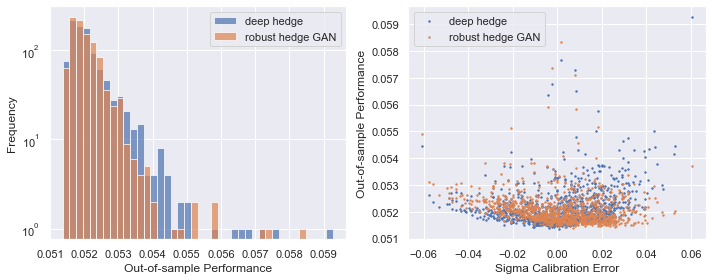

In [74]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

vals_n, bins = np.histogram(oosp, bins=40)
vals_r = np.histogram(oosp_robust, bins=bins)[0]
bin_centers = 0.5*(bins[1:]+bins[:-1])
axs[0].hist(oosp, bins=bins, label='deep hedge', color='C0', alpha=.7)
axs[0].hist(oosp_robust, bins=bins, label='robust hedge GAN', color='C1', alpha=.7)
axs[0].set_xlabel('Out-of-sample Performance')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')
axs[0].legend()
# axs[0].set_title('')

axs[1].scatter([bs_parameters.sigma - v for v in volatilities_for_scenarios], oosp, label='deep hedge', s=2)
axs[1].scatter([bs_parameters.sigma - v for v in volatilities_for_scenarios], oosp_robust, label='robust hedge GAN', s=2)
axs[1].set_xlabel('Sigma Calibration Error')
axs[1].set_ylabel('Out-of-sample Performance')
axs[1].legend()
# axs[1].set_title()

plt.tight_layout()
# plt.savefig('figs/BlackScholesRobustification.pdf')
plt.show()

In [72]:
print('Naive:  ', np.mean(oosp))
print('Robust: ', np.mean(oosp_robust))
print()
print('Naive:  ', np.std(oosp))
print('Robust: ', np.std(oosp_robust))

Naive:   0.0521750201433897
Robust:  0.052086425226181746

Naive:   0.0007295896779737821
Robust:  0.0005935807837077448


In [76]:
np.std(oosp_robust)/np.std(oosp)

0.8135816632661779

In [ ]:
# torch.save(dh.state_dict(), 'resources/network-states/deep_hedge_for_heston.pt')

### Loss curves

In [ ]:
i = 0

In [ ]:
coef_config = BlackScholesCoefficientConfig(
    BlackScholesParameterSet(drift=bs_parameters.drift, sigma=volatilities_for_scenarios[i]),
    initial_asset_price=1.0,
)
drift_coef, diffusion_coef = BlackScholesDriftCoefficient(coef_config), BlackScholesDiffusionCoefficient(coef_config)
gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
g = SdeGenerator(generator_config=gen_config)

In [ ]:
strategy_config = StrategyNetConfig(dimension_of_asset=1, number_of_layers=3, nodes_in_intermediate_layers=36)
initial_asset_price_for_deep_hedge = torch.tensor([initial_asset_price], dtype=torch.float32)
dh = DeepHedge(DeepHedgeConfig(derivative, initial_asset_price_for_deep_hedge, strategy_config))
dh.load_state_dict(torch.load(f'resources/network-states/bs_test/scenario_{i}.pt'))

In [ ]:
g_opt = torch.optim.Adam(g.parameters())
gen_adapters = AdapterList([])
gen_train_config = SdeGeneratorTrainerConfig(g, penalizers[i], g_opt, gen_adapters)

h_opt = torch.optim.Adam(dh.parameters())
hedge_adapters = AdapterList([ConvertToIncrements()])
dh_train_config = DeepHedgeTrainerConfig(dh, hedge_objective, h_opt, hedge_adapters)

In [ ]:
batches = [noise_generator(1000) for _ in range(100)]

In [ ]:
h_losses = QuantityLogger()
g_losses = QuantityLogger()
p_losses = QuantityLogger()

for batch in batches:
    generated = g(batch)
    profit_and_loss = dh(dh_train_config.generation_adapters(generated))
    hedge_loss = hedge_objective(profit_and_loss)
    dh.zero_grad()
    hedge_loss.backward()
    dh_train_config.optimizer.step()
    dh_train_config.scheduler.step()
    h_losses.update(hedge_loss.item())
    
    generated = g(batch)
    profit_and_loss = dh(dh_train_config.generation_adapters(generated))
    hedge_loss = hedge_objective(profit_and_loss)
    penalty = penalizers[i](gen_train_config.penalization_adapters(generated))
    generation_loss = penalty - hedge_loss
    g.zero_grad()
    generation_loss.backward()
    gen_train_config.optimizer.step()
    gen_train_config.scheduler.step()
    g_losses.update(generation_loss.item())
    p_losses.update(penalty.item())

In [ ]:
import mpl_axes_aligner

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(np.load('resources/network-states/bs_test/losses.npz', allow_pickle=True)['scenario_0'], label='Hedge Loss')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].legend()
# axs[0].set_title()

axs[1].plot(h_losses.history, c='C0', label='Hedge Loss')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Loss')
# axs[1].set_title('')

axs_clone = axs[1].twinx()
axs_clone.plot(g_losses.history, c='C1', label='Generation Loss')
axs[1].legend()
axs_clone.legend(loc='lower left')

axs_clone.grid(False)

mpl_axes_aligner.align.yaxes(axs[1], h_losses.history[0], axs_clone, g_losses.history[0])

plt.tight_layout()
# plt.savefig('figs/BlackScholesLossCurves.pdf')
plt.show()

In [ ]:
print(g_losses.history[0])
print(h_losses.history[0])

In [ ]:
dh.load_state_dict(torch.load('resources/network-states/deep_hedge_for_heston.pt'))
robust_dh_gan.hedge_config.reset_scheduler()

In [ ]:
inputs = torch.diff(heston_generator(5000), 1, 1)[:, :, 0:1]

In [ ]:
dh.eval()
n_res = np.sum(dh(inputs).detach().numpy() * inputs.numpy(), axis=(1, 2))
term_a_v = np.sum(inputs.numpy(), axis=1)[:, 0] + 1.0

In [ ]:
plt.scatter(term_a_v, n_res, s=.1)
plt.show()

In [ ]:
# This is not necessary, we start with the optimal initialization.
# robust_dh_gan.deactivate_hedge_training()
# robust_dh_gan.fit(5, callbacks=[PrintHestonParameters()])
# robust_dh_gan.activate_hedge_training()

In [ ]:
dh.train()
generator.train()
robust_dh_gan.activate_generation_training()
robust_dh_gan.fit(100, callbacks=[PrintMetrics()])

In [ ]:
dh.eval()
r_res = np.sum(dh(inputs).detach().numpy() * inputs.numpy(), axis=(1, 2))
term_a_v = np.sum(inputs.numpy(), axis=1)[:, 0] + 1.0

In [ ]:
plt.scatter(term_a_v, r_res, s=.1)
plt.scatter(term_a_v, n_res, s=.1)
plt.show()

In [ ]:
plt.scatter(term_a_v, r_res - n_res, s=.1)